In [2]:
# !pip install pandas nltk scikit-learn tweepy matplotlib seaborn

In [3]:
import pandas as pd

# Load the dataset (update the file path if needed)
data = pd.read_csv('training.1600000.processed.noemoticon.csv', 
                   encoding='latin-1', 
                   names=['sentiment', 'id', 'date', 'query', 'user', 'text'])

# Display the first 5 rows
print(data.head())

   sentiment          id                          date     query  \
0          0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1          0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2          0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3          0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4          0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  


In [4]:
data['sentiment'] = data['sentiment'].map({0: 0, 4: 1})
print(data['sentiment'].value_counts())

sentiment
0    800000
1    800000
Name: count, dtype: int64


In [5]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abhip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abhip\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
import nltk
nltk.download("punkt_tab")


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\abhip\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [7]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Set stop words
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|\#\w+', '', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    # Join tokens back into a string
    return ' '.join(tokens)

# Apply preprocessing to the text column
data['cleaned_text'] = data['text'].apply(preprocess_text)
print(data[['text', 'cleaned_text']].head())

                                                text  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1  is upset that he can't update his Facebook by ...   
2  @Kenichan I dived many times for the ball. Man...   
3    my whole body feels itchy and like its on fire    
4  @nationwideclass no, it's not behaving at all....   

                                        cleaned_text  
0      thats bummer shoulda got david carr third day  
1  upset cant update facebook texting might cry r...  
2  dived many times ball managed save rest go bounds  
3                   whole body feels itchy like fire  
4                           behaving im mad cant see  


In [8]:
data = data[data['cleaned_text'] != '']

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000)

# Convert text to TF-IDF features
X = vectorizer.fit_transform(data['cleaned_text'])

# Get the labels
y = data['sentiment']

# Check the shape of X
print(X.shape)

(1592403, 5000)


In [10]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the sizes
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (1273922, 5000)
Testing set size: (318481, 5000)


In [11]:
from sklearn.linear_model import LogisticRegression

# Initialize the model
model = LogisticRegression(max_iter=1000)

# Train the model
model.fit(X_train, y_train)

# Print a confirmation
print("Model trained successfully!")

Model trained successfully!


In [12]:
from sklearn.metrics import accuracy_score, classification_report

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Detailed report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

Accuracy: 0.7758453408523586

Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.76      0.77    158563
    Positive       0.77      0.79      0.78    159918

    accuracy                           0.78    318481
   macro avg       0.78      0.78      0.78    318481
weighted avg       0.78      0.78      0.78    318481



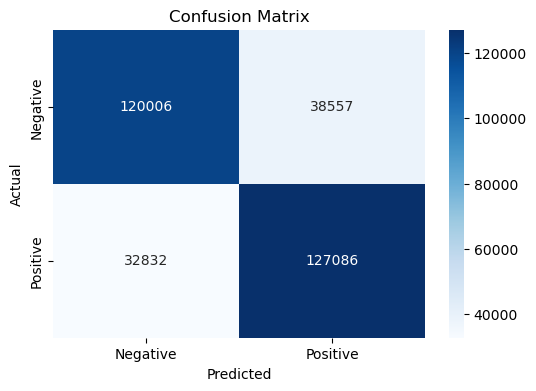

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [14]:
# Function to predict sentiment of new text
def predict_sentiment(text):
    # Preprocess the text
    cleaned_text = preprocess_text(text)
    # Convert to TF-IDF
    text_vector = vectorizer.transform([cleaned_text])
    # Predict
    prediction = model.predict(text_vector)
    return 'Positive' if prediction[0] == 1 else 'Negative'

# Test examples
test_texts = ["I hate this movie", 
              "This is the best day ever."]
for text in test_texts:
    print(f"Text: {text}")
    print(f"Sentiment: {predict_sentiment(text)}\n")

Text: I hate this movie
Sentiment: Negative

Text: This is the best day ever.
Sentiment: Positive



In [15]:
import os
print(os.getcwd())

c:\Users\abhip\Downloads\Sentiment Analysis


In [16]:
print(model)


LogisticRegression(max_iter=1000)


In [18]:
import joblib
# Save the model to a file
joblib.dump(model, 'sentiment_model.pkl')
print("Model saved as sentiment_model.pkl")

Model saved as sentiment_model.pkl


In [19]:

# Save the vectorizer to a file
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
print("Vectorizer saved as tfidf_vectorizer.pkl")


Vectorizer saved as tfidf_vectorizer.pkl
